In [1]:
import numpy as np
import os 
import re
import random
import pandas as pd
import subprocess
import shutil
import time
import sys

from pymatgen.core import Element
from pymatgen.io.vasp import Poscar
from pymatgen.io.cif import CifWriter
from pymatgen.core import Composition
from pymatgen.analysis.structure_matcher import StructureMatcher

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.patches import Rectangle
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
#print per ogni coppia il ground state e l'entalpia del template che prendo

#Needs df of Individuals, fitness treshold, file gatheredPoscars and return best non duplicated structures (with symm>75)
def best_structures(individuals_df, fitness_upto, all_poscars):
    fitness_gs = individuals_df['fitness'].iloc[0]
    uniques = []
    SGs=[]
    fitness = []
    structure_gs = Poscar.from_str(find_poscar(all_poscars, individuals_df['ID'].iloc[0]))
    
    if (individuals_df['spacegroup'].iloc[0] > 75):
        uniques.append(structure_gs)
        SGs.append(individuals_df['spacegroup'].iloc[0])
        fitness.append(individuals_df['fitness'].iloc[0])

    for i, line_individuals_df in individuals_df.iterrows():
        if line_individuals_df['fitness'] - fitness_gs >= fitness_upto:
            break
        if line_individuals_df['spacegroup'] < 75:
            continue
        new_structure = Poscar.from_str(find_poscar(all_poscars, line_individuals_df['ID']))

        check_dupilcate = False
        
        if StructureMatcher(ltol = 1.0, stol = 1.0, angle_tol = 10, scale=True).fit(structure_gs.structure, new_structure.structure):
            check_dupilcate = True 
        
        for structure in uniques:
            if StructureMatcher(ltol = 1.0, stol = 1.0, angle_tol = 10, scale=True).fit(structure.structure, new_structure.structure):
                check_dupilcate = True
        if not check_dupilcate:
            uniques.append(new_structure)
            SGs.append(line_individuals_df['spacegroup'])
            fitness.append(line_individuals_df['fitness'])
    return uniques, SGs, fitness

def read_individuals(individuals):
    column_names = {0 : "Generation", 1 : "ID", 2 : "GenMode", 
    4 : 'A', 5 : 'B', 7 : "enthalpy", 10 : "fitness", 15 : "spacegroup"}

    individuals = pd.read_csv(individuals, sep="\s+", header=None, skiprows=2,usecols=column_names)
    individuals.rename(columns=column_names, inplace=True)
    individuals.sort_values("fitness", inplace=True)
    return individuals

#Needs in input the name of the file with all the poscars, the id of the structure to be extracted and the name of the output poscar
def find_poscar(all_poscars, id):
    end=-1
    with open(all_poscars,'r') as file:
        testo_input = file.readlines()              
    for i, line in enumerate(testo_input):
        if line.startswith('EA'+str(id)):   
            init = i
            simm=int(line[line.find(':')+1:])
        if line.startswith('EA'+str(id+1)):
            end = i-1
            break
    if end == -1:                            
        end = len(testo_input)-1
        
    poscar_str=''
    for i in range(end-init+1):
        poscar_str+=testo_input[init+i]
    return poscar_str

In [ ]:
df_gs = pd.read_csv('./AB/A1B_relaxation/GroundStates.txt', header=None)
df_temp = pd.read_csv('./AB/A1B_relaxation/RELAX_DATA', header=None)
ticks_labels = []
for i in range(1,22):
    ticks_labels.append(df_temp.loc[0,i])

for i in range(1,29):
    diff = np.zeros(21)
    for j in range(1,22):
        diff[j-1] = float(df_temp.loc[i,j])-float(df_gs[df_gs[0]==df_temp.loc[i,0]][1].values[0])
    plt.barh(np.arange(1,22), diff)
    plt.title(df_temp.loc[i,0])
    plt.yticks(np.arange(1,22), ticks_labels)
    plt.show()
    plt.savefig('/home/seraf/PRESENTATION/'+df_temp.loc[i,0]+'.png')

# GRAFICI


In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.patches import Rectangle
from scipy.cluster.hierarchy import dendrogram, linkage

import numpy as np

In [55]:
x = np.arange(1,22,1)
with open('IMPORTANT_RESULTS.txt' , 'r') as file_data:
    content = file_data.readlines()

for line in content:
    if line.startswith('MEANS:'):
        means = np.array([float(x) for x in line[line.find('[')+1:line.find(']')].split()])
    if line.startswith('STDS:'):
        std = np.array([float(x) for x in line[line.find('[')+1:line.find(']')].split()])


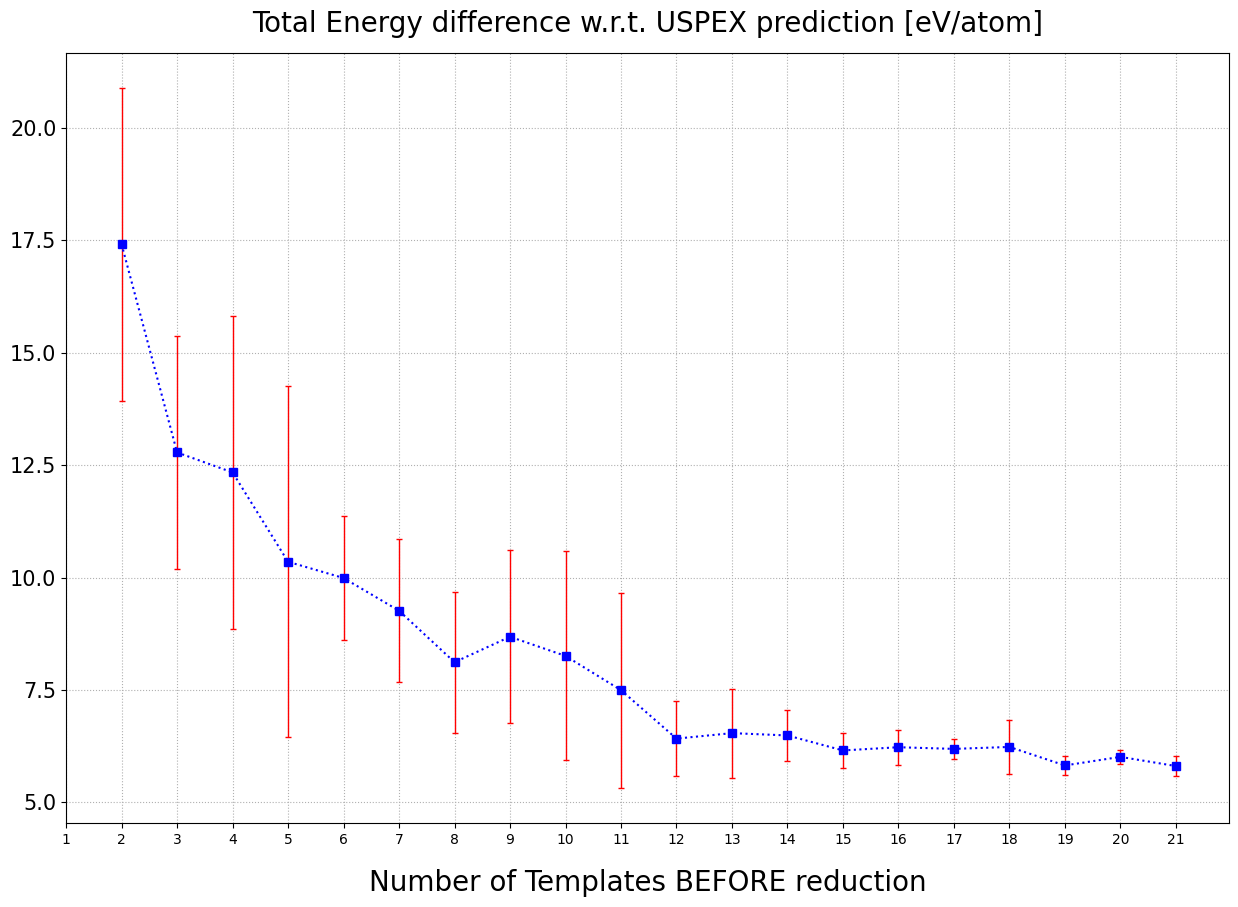

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.errorbar(x[1:], means[1:], yerr=std[1:], fmt='bs:', ecolor='red', elinewidth=1, capsize=2)

ax.set_xlabel('Number of Templates BEFORE reduction', fontsize=20)
ax.set_title('Total Energy difference w.r.t. USPEX prediction [eV/atom]', fontsize=20, pad=15)

ax.xaxis.set_label_coords(0.5, -0.06)
ax.yaxis.set_label_coords(-0.08, 0.5)

ax.grid(True, ls=':')

ax.set_xticks(x)
y_ticks  = np.arange(5,22.5,2.5)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=15)


plt.show()

cartella =  '/home/seraf/PRESENTATION'
nome = 'TotalErrors.png'

fig.savefig(os.path.join(cartella, nome))

In [57]:
x = np.arange(1,16,1)
with open('IMPORTANT_RESULTS.txt' , 'r') as file_data:
    content = file_data.readlines()

for line in content:
    if line.startswith('NUM FINAL TEMPLATES:'):
        means = np.array([float(x) for x in line[line.find('[')+1:line.find(']')].split(',')])
    if line.startswith('STDS NUM FINAL TEMPLATES:'):
        std = np.array([float(x) for x in line[line.find('[')+1:line.find(']')].split(',')])

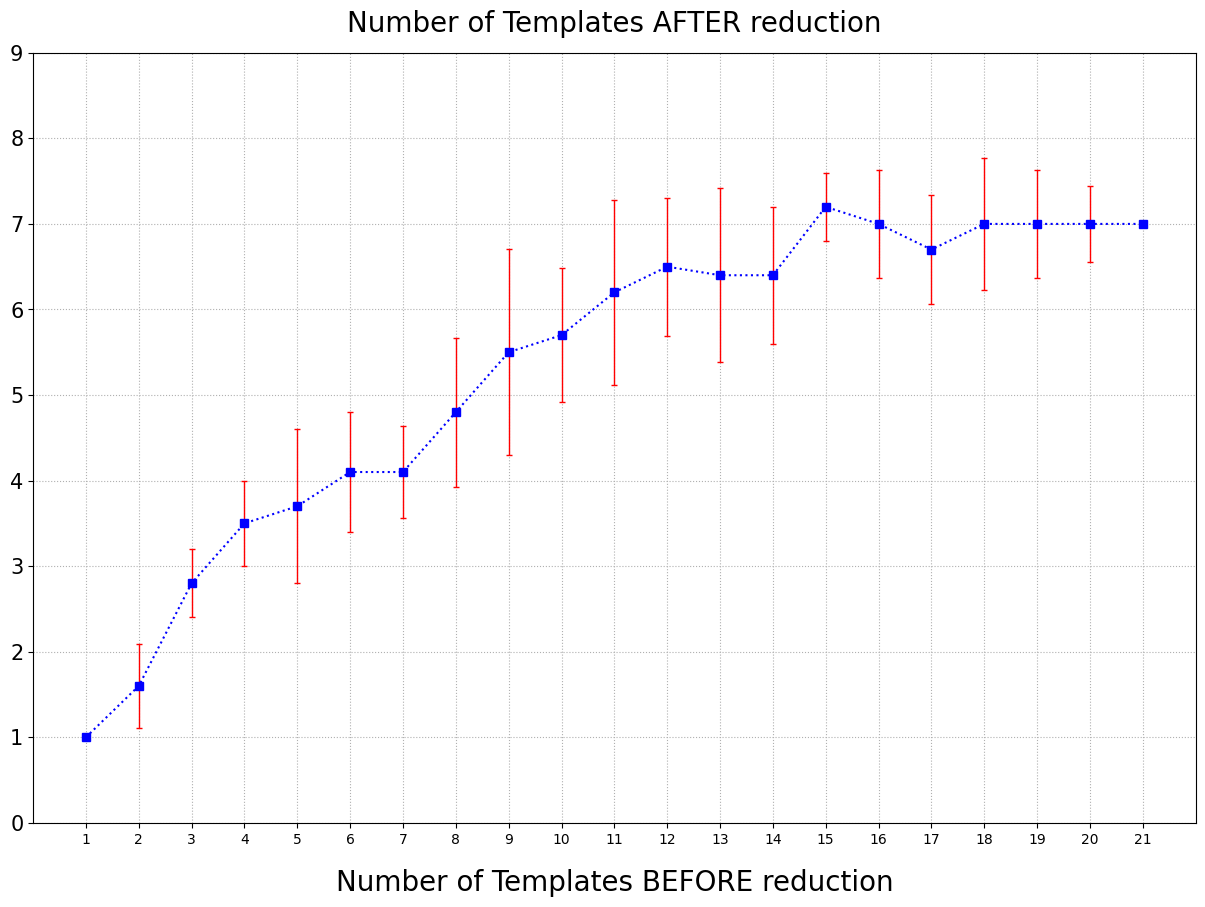

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.errorbar(x, means, yerr=std, fmt='bs:', ecolor='red', elinewidth=1, capsize=2)

ax.set_xlabel('Number of Templates BEFORE reduction', fontsize=20)
ax.set_title('Number of Templates AFTER reduction', fontsize=20, pad=15)

ax.xaxis.set_label_coords(0.5, -0.06)
ax.yaxis.set_label_coords(-0.08, 0.5)

ax.grid(True, ls=':')

ax.set_xticks(x)
y_ticks  = np.arange(0,10,1)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=15)


plt.show()

cartella =  '/home/seraf/PRESENTATION'
nome = 'NTempRedu.png'

fig.savefig(os.path.join(cartella, nome))

In [27]:
with open('IMPORTANT_RESULTS.txt',  'r') as file_data:
    content = file_data.readlines()

means_dif = np.zeros((21,28))
single_dif = []
idx = 0

flag = False 

for line in content:

    if line.startswith('STDS DIFFERENCES:'):
        flag = False

    elif line[-2] == ']' and flag:
        single_dif.extend([float(x) for x in line[:line.find(']')].split()])
        means_dif[idx] = single_dif
        single_dif = []
        idx += 1
        
    elif line.startswith('   ')  and flag:
        single_dif.extend([float(x) for x in line.split()])
        continue

    elif line[1] == '[' and flag:
        single_dif.extend([float(x) for x in line[line.find('[')+1:].split()])

    elif line.startswith('DIFFERENCES'):
        flag = True
        single_dif.extend([float(x) for x in line[line.find('[')+2:].split()])
        

In [33]:
with open('IMPORTANT_RESULTS.txt',  'r') as file_data:
    content = file_data.readlines()

std_dif = np.zeros((21,28))
single_dif = []
idx = 0

flag = False 

for line in content:

    if line[-2] == ']' and flag:
        single_dif.extend([float(x) for x in line[:line.find(']')].split()])
        #print(single_dif)
        std_dif[idx] = single_dif
        single_dif = []
        idx += 1
        
    elif line.startswith('  ')  and flag:
        single_dif.extend([float(x) for x in line.split()])
        continue

    elif line[1] == '[' and flag:
        single_dif.extend([float(x) for x in line[line.find('[')+1:].split()])

    elif line.startswith('STDS DIFFERENCES:'):
        flag = True
        single_dif.extend([float(x) for x in line[line.find('[')+2:].split()])

# USPEX VS QE

In [7]:
df = pd.read_csv('./AB/A1B_relaxation/GroundStates.txt', header=None)
df

,0,1
0,COUPLES,ENT
1,BNa,-657.9911059083599
2,MgNa,-1423.8666288617599
3,NNa,-759.6513620769399
4,BeNa,-807.16357166736
5,NaO,-843.5751569601599
6,LiNa,-714.87153031028
7,CNa,-700.04496709822
8,BMg,-844.5314877292
9,BN,-180.52723081924


In [25]:
elements = ['Na','N', 'Be', 'B', 'Li', 'O', 'Mg', 'C']

for i in range(len(elements)):
    for j in range(i+1, len(elements)):
        couple = [elements[i],elements[j]]
        couple.sort()

        A = couple[0]
        B = couple[1]
        df_individuals = read_individuals(f'./AB/OUTPUTFILES/{A+B}/{A}{B}_Individuals')
        print(A+B, float(df[df[0]==f'{A}{B}'][1].values[0]) - float(df_individuals['fitness'].iloc[0])/2)
        

NNa 0.3426379230601242
BeNa 0.3394283326400682
BNa 0.28439409164002427
LiNa 0.3394696897199765
NaO 0.35084303984012877
MgNa 0.6723711382401234
CNa 0.2880329017799568
BeN 2.0723114721200204
BN 1.7362691807599901
LiN 2.058110322019985
NO 2.4225955170933275
MgN 2.9827981094600773
CN 1.8236955676866842
BBe 2.012029495720043
BeLi 2.345024871199996
BeO 2.0095069308400184
BeMg 3.4960526688798836
BeC 2.114455770940026
BLi 1.932557467253332
BO 2.07343334440003
BMg 3.17751227079998
BC 1.8407931855799973
LiO 2.0291779146800764
LiMg 3.8423654451200946
CLi 2.0866911772600076
MgO 2.8463004859600005
CO 1.9740269444199612
CMg 3.248606534079954


In [17]:
df_individuals['fitness'].iloc[0]

-1778.626